# Example to connect to postgres

This is a tutorial to connect to our PostgreSQL database using python.

First you need to install the following libraries:
- psycopg2
- python-dotenv

Then you need to create a file with the name ".env". This file will contain the connection information and your credentials. This is an example:

```
DB_HOST=host_name
DB_NAME=postgres
DB_USER=my_user
DB_PASSWORD=my_password
DB_PORT=5432
```

After that you´re all set. We will import your credentials and connect to the database.

In [1]:
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable

# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [2]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

Now we can query our data (write sql code) and store it as a pandas dataframe

In [3]:
import pandas as pd
from sklearn.metrics import mean_squared_error

C:\Users\xlow6\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
#query="""
#    select * 
#    from agg.t_msb1m  
#    where year = 2019 and site=84 and min = 0 and month = 6
#"""

In [4]:
query="""
    select * 
    from agg.tidy_data  
    where year = 2019 and site = 84 and month = 6 
"""

In [5]:
df = pd.read_sql_query(query, conn)

C:\Users\xlow6\AppData\Local\Temp\ipykernel_51676\1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [56]:
# Average hourly
df = df.groupby(['year','month', 'day', 'hour']).mean().reset_index()

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   year                       0 non-null      object
 1   month                      0 non-null      object
 2   day                        0 non-null      object
 3   hour                       0 non-null      object
 4   timestamp                  0 non-null      object
 5   site                       0 non-null      object
 6   min                        0 non-null      object
 7   day_of_week                0 non-null      object
 8   season                     0 non-null      object
 9   net_load                   0 non-null      object
 10  precipitation              0 non-null      object
 11  precipitation_probability  0 non-null      object
 12  wind_direction             0 non-null      object
 13  wind_speed                 0 non-null      object
 14  solar_radiation       

In [21]:
#df = df.rename(columns={'min': 'minute'})
df['datetime'] = pd.to_datetime(df[['year','month', 'day', 'hour']])

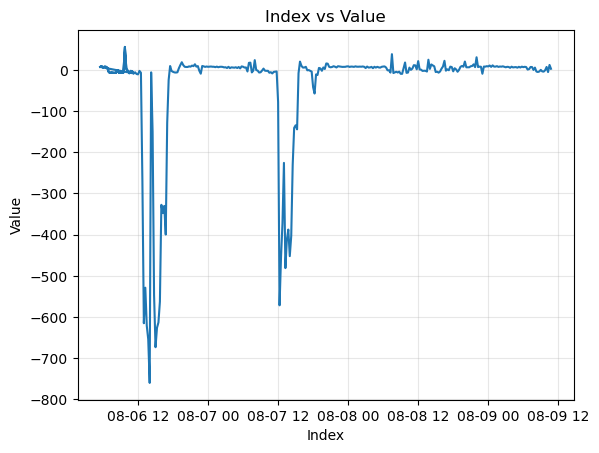

In [22]:
import matplotlib.pyplot as plt

plt.plot(df['datetime'],df['net_load'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Index vs Value')
plt.grid(alpha=0.3) 
plt.show()

(array([18114. , 18114.5, 18115. , 18115.5, 18116. , 18116.5, 18117. ]),
 [Text(18114.0, 0, '08-06 00'),
  Text(18114.5, 0, '08-06 12'),
  Text(18115.0, 0, '08-07 00'),
  Text(18115.5, 0, '08-07 12'),
  Text(18116.0, 0, '08-08 00'),
  Text(18116.5, 0, '08-08 12'),
  Text(18117.0, 0, '08-09 00')])

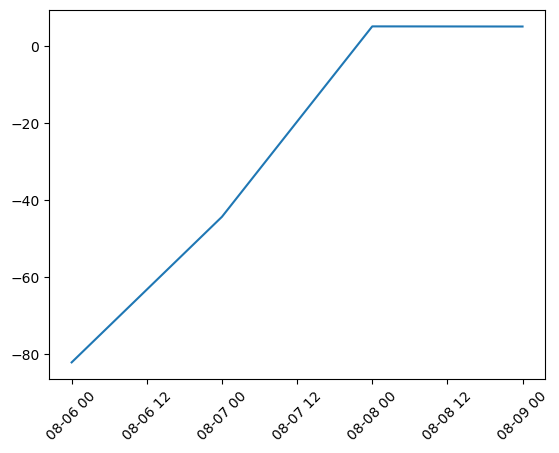

In [23]:
avg_load_day = df.groupby(df['datetime'].dt.date)['net_load'].mean()

plt.plot(avg_load_day)

plt.xticks(rotation=45) 

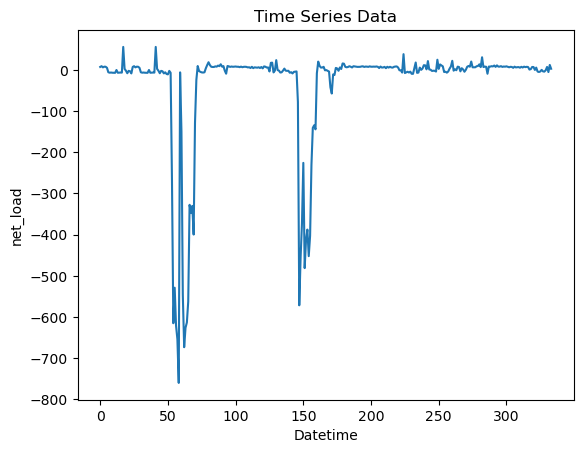

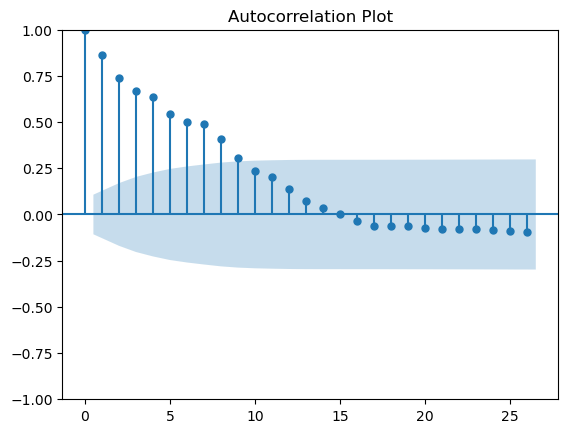

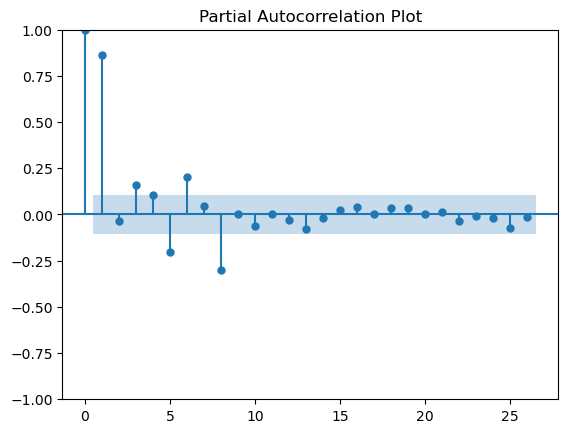

                               SARIMAX Results                                
Dep. Variable:               net_load   No. Observations:                  334
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1873.135
Date:                Wed, 27 Mar 2024   AIC                           3752.270
Time:                        14:33:51   BIC                           3763.694
Sample:                             0   HQIC                          3756.826
                                - 334                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8677      0.023     37.824      0.000       0.823       0.913
ma.L1         -0.9986      0.196     -5.100      0.000      -1.382      -0.615
sigma2      4463.1807    812.856      5.491      0.0

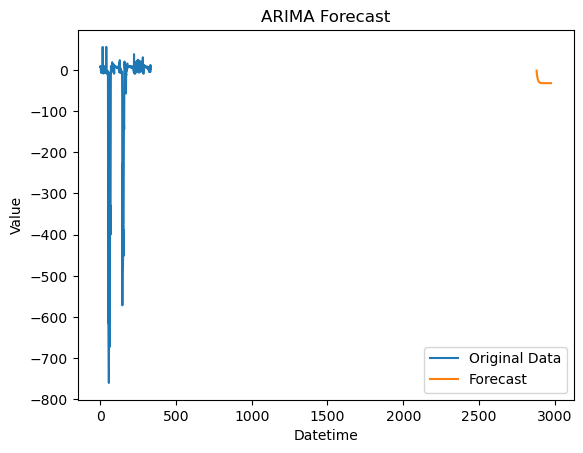

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'df' is your DataFrame with datetime index and 'value' column

# Plot the time series data
df['net_load'].plot()
plt.xlabel('Datetime')
plt.ylabel('net_load')
plt.title('Time Series Data')
plt.show()

# Plot autocorrelation and partial autocorrelation plots
plot_acf(df['net_load'])
plt.title('Autocorrelation Plot')
plt.show()

plot_pacf(df['net_load'])
plt.title('Partial Autocorrelation Plot')
plt.show()

# Fit ARIMA model
order = (1, 1, 1)  # Example: ARIMA(2,1,1) model
model = ARIMA(df['net_load'], order=order)
fitted_model = model.fit()

# Summary of the model
print(fitted_model.summary())

# Forecast future values for the next day (96 15-minute intervals)
forecast_steps = 96
forecast = fitted_model.forecast(steps=forecast_steps)

# Generate datetime index for the forecasted values
last_datetime = df.index[-1]
#forecast_index = pd.date_range(start=last_datetime, periods=forecast_steps + 1, freq='15T')[1:]  # Start from the next interval
forecast_index = list(range(2879, 2975))

# Plot the original data and forecasted values
plt.plot(df.index, df['net_load'], label='Original Data')
plt.plot(forecast_index, forecast, label='Forecast')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()


    timestamp  site  year  month  day  hour  minute  day_of_week  season  \
286      None    34  2019      8    8    23       0            3       3   
287      None    34  2019      8    8    23      15            3       3   
288      None    34  2019      8    8    23      30            3       3   
289      None    34  2019      8    8    23      45            3       3   
290      None    34  2019      8    9     0       0            3       3   
291      None    34  2019      8    9     0      15            3       3   
292      None    34  2019      8    9     0      30            3       3   
293      None    34  2019      8    9     0      45            3       3   
294      None    34  2019      8    9     1       0            4       3   
295      None    34  2019      8    9     1      15            4       3   
296      None    34  2019      8    9     1      30            4       3   
297      None    34  2019      8    9     1      45            4       3   
298      Non

c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available

Forecasted Values: 286    39.235689
287    57.339552
288    67.748739
289    71.434276
290    64.916297
291    25.533136
292    43.704887
293    28.941961
294    16.892466
295     5.229570
296     6.505965
297     5.636890
298    -3.880467
299    62.461950
300    63.297866
301    37.312868
302    25.001696
303    29.293804
304    43.266290
305    50.381823
306    68.391079
307    64.983658
308    71.655547
309    62.914204
Name: predicted_mean, dtype: float64
   timestamp  site  year  month  day  hour  minute  day_of_week  season  \
0       None    34  2019      8    8    23       0            3       3   
1       None    34  2019      8    8    23      15            3       3   
2       None    34  2019      8    8    23      30            3       3   
3       None    34  2019      8    8    23      45            3       3   
4       None    34  2019      8    9     0       0            3       3   
5       None    34  2019      8    9     0      15            3       3   
6       Non

c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecasted Values: 310    35.537024
311    52.006465
312    60.149327
313    62.512419
314    53.528627
315    16.720294
316    32.639016
317    18.874083
318    -5.617172
319   -16.697372
320   -15.711777
321   -16.886835
322   -41.983388
323    18.883203
324    19.676813
325    -4.406445
326   -32.731164
327   -28.760121
328   -16.006274
329    -9.657253
330    -8.487595
331   -11.737379
332    -5.514631
333   -13.549356
Name: predicted_mean, dtype: float64
   timestamp  site  year  month  day  hour  minute  day_of_week  season  \
0       None    34  2019      8    8    23       0            3       3   
1       None    34  2019      8    8    23      15            3       3   
2       None    34  2019      8    8    23      30            3       3   
3       None    34  2019      8    8    23      45            3       3   
4       None    34  2019      8    9     0       0            3       3   
5       None    34  2019      8    9     0      15            3       3   
6       Non

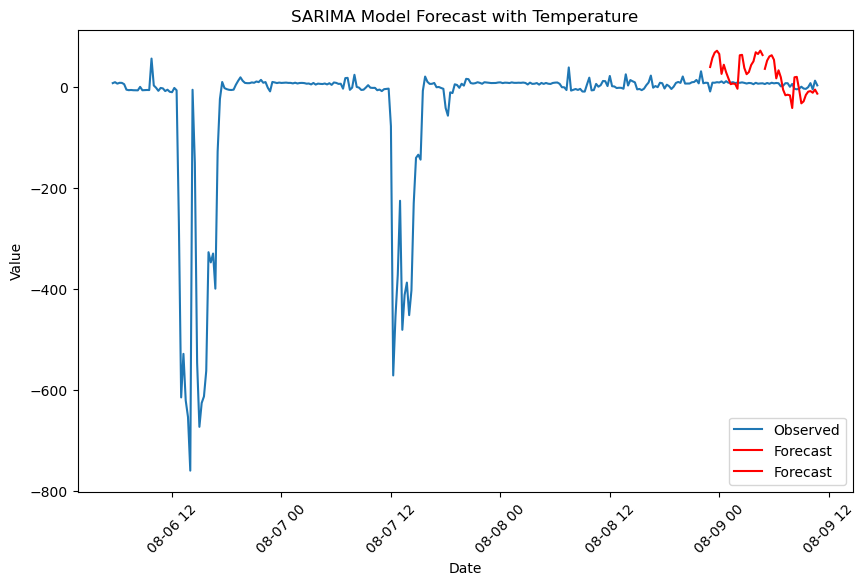

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt

df = df.sort_values(by='datetime')
results = pd.DataFrame()
for x in range(2,0,-1):
    vals = x*-24
    train_data = df.iloc[:vals]  
    test_data = df.iloc[vals:]
    test_data = test_data.iloc[:24]

    model = SARIMAX(train_data['net_load'], exog=train_data[['solar_radiation','precipitation_probability']], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
    sarimax_model = model.fit()

    sarimax_params = sarimax_model.params

    print("SARIMAX Parameters:")
    print(sarimax_params)


    forecast_horizon = 24
    forecast = sarimax_model.forecast(steps=forecast_horizon, exog=test_data[['solar_radiation','precipitation_probability']])
    #print('Forecasted Values:', forecast)
    df_final = pd.concat([test_data, forecast], axis=1)
    results = pd.concat([results, df_final], ignore_index=True)
    results = results.rename(columns={results.columns[-1]: 'forecast'})

plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['net_load'], label='Observed')
plt.plot(results['datetime'], results['forecast'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.xticks(rotation=45) 
plt.grid(alpha=0.3)
plt.show()

c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


587   2019-06-29 00:00:00
588   2019-06-29 01:00:00
589   2019-06-29 02:00:00
590   2019-06-29 03:00:00
591   2019-06-29 04:00:00
592   2019-06-29 05:00:00
593   2019-06-29 06:00:00
594   2019-06-29 07:00:00
595   2019-06-29 08:00:00
596   2019-06-29 09:00:00
597   2019-06-29 10:00:00
598   2019-06-29 11:00:00
599   2019-06-29 12:00:00
600   2019-06-29 13:00:00
601   2019-06-29 14:00:00
602   2019-06-29 15:00:00
603   2019-06-29 16:00:00
604   2019-06-29 17:00:00
605   2019-06-29 18:00:00
606   2019-06-29 19:00:00
607   2019-06-29 20:00:00
608   2019-06-29 21:00:00
609   2019-06-29 22:00:00
610   2019-06-29 23:00:00
Name: datetime, dtype: datetime64[ns]
Forecasted Values: 672   -15.946875
673   -31.949561
674   -47.236584
675   -56.894287
676   -65.715953
677   -70.611988
678   -75.774508
679   -77.993674
680   -81.182869
681   -81.960119
682   -84.094214
683   -84.100664
684   -85.671505
685   -85.266486
686   -86.536727
687   -85.912116
688   -87.021941
689   -86.280143
690   -87.304

c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Series([], Name: datetime, dtype: datetime64[ns])
Forecasted Values: 696    11.508533
697     7.432244
698    10.300761
699     8.079322
700     9.819665
701     8.481952
702     9.510327
703     8.727097
704     9.325089
705     8.877271
706     9.213759
707     8.969722
708     9.147417
709     9.027124
710     9.108389
711     9.063241
712     9.085947
713     9.086433
714     9.073577
715     9.101776
716     9.067324
717     9.112352
718     9.064786
719     9.120033
Name: predicted_mean, dtype: float64


c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


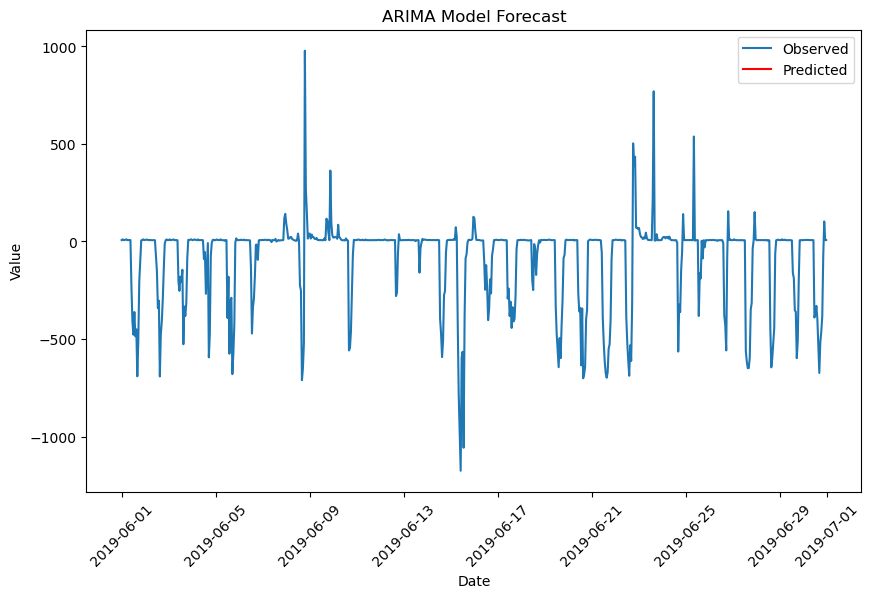

In [ ]:
results= pd.DataFrame()
for x in range(2, 0, -1):
    break_val = -24*x
    break_val2 = -24*(x-1)
    train = df.iloc[:break_val]
    test = df.iloc[break_val:break_val2]

    model = SARIMAX(train['net_load'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 2))  # Example order, adjust as needed
    arima_model = model.fit()


    #predictions = arima_model.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
    #mse = mean_squared_error(test['net_load'], predictions)
    #print('Mean Squared Error:', mse)
    print(test['datetime'])
    forecast_horizon = 24
    forecast = arima_model.forecast(steps=forecast_horizon)
    print('Forecasted Values:', forecast)
    forecast_df = pd.DataFrame({'forecast': forecast}, index=test.index)

    # Merge forecast_df with test DataFrame on index
    test_with_forecast = pd.merge(test, forecast_df, left_index=True, right_index=True)

    # Concatenate test_with_forecast with results
    results = pd.concat([results, test_with_forecast], ignore_index=True)



plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['net_load'], label='Observed')
plt.plot(results['datetime'],results['forecast'], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.xticks(rotation=45) 
plt.show()

In [ ]:
print(forecast_df)

      forecast datetime
672  11.691917      NaT
673  16.437081      NaT
674  17.639491      NaT
675  20.651374      NaT
676  20.308211      NaT
677  22.360694      NaT
678  21.386370      NaT
679  23.043794      NaT
680  21.819883      NaT
681  23.320880      NaT
682  21.998780      NaT
683  23.438225      NaT
684  22.077530      NaT
685  23.492780      NaT
686  22.116916      NaT
687  23.522656      NaT
688  22.140831      NaT
689  23.542835      NaT
690  22.158667      NaT
691  23.559201      NaT
692  22.174112      NaT
693  23.574070      NaT
694  22.188619      NaT
695  23.588350      NaT


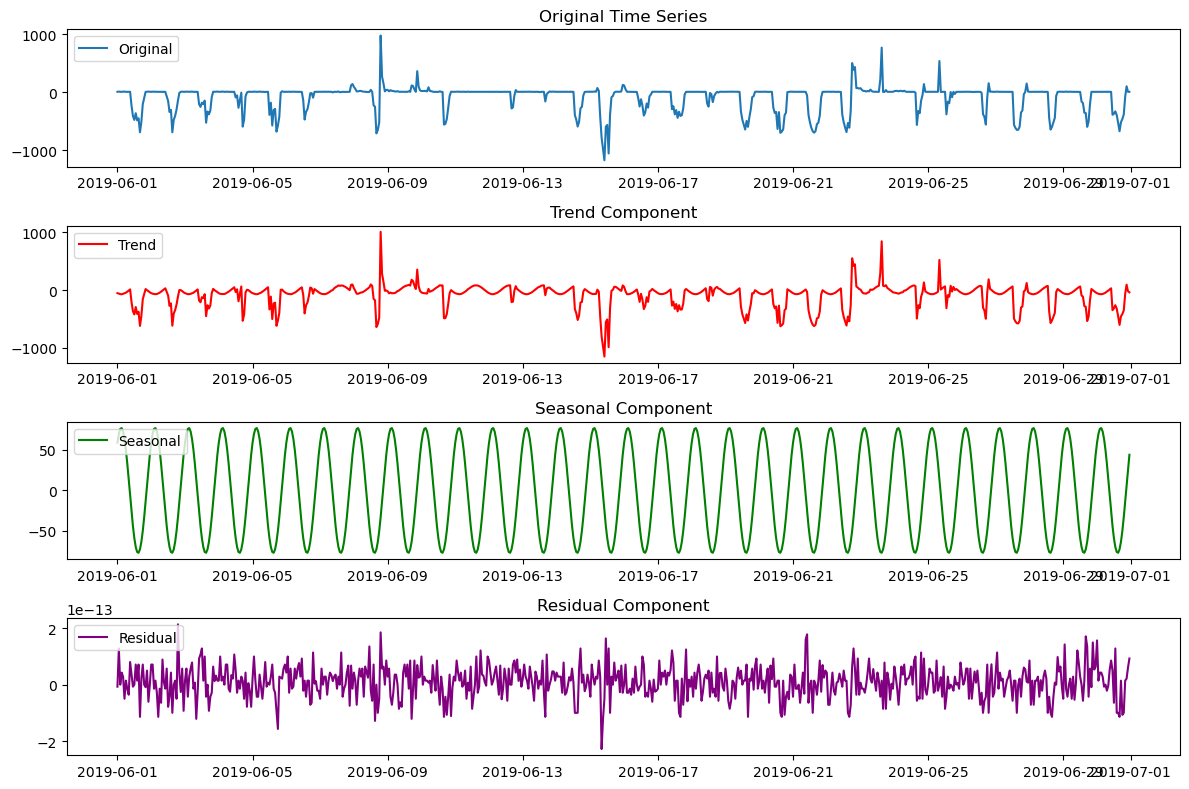

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#df.set_index('datetime', inplace=True)

# Function to decompose time series using Fourier transform
def decompose_fourier(data):
    
    # Compute FFT of the time series data
    fft_values = np.fft.fft(data)
    
    # Compute the frequencies corresponding to the FFT values
    frequencies = np.fft.fftfreq(len(data))
    
    # Find the index of the highest amplitude frequency (excluding the DC component)
    highest_freq_index = np.argmax(np.abs(fft_values[1:])) + 1
    
    # Construct the signal corresponding to the highest amplitude frequency
    reconstructed_signal = np.fft.ifft(np.zeros_like(fft_values))
    reconstructed_signal[highest_freq_index] = fft_values[highest_freq_index]
    
    # Compute the trend component by removing the highest amplitude frequency from the original signal
    trend_component = np.fft.ifft(fft_values - reconstructed_signal)
    
    # Compute the seasonal component by keeping only the highest amplitude frequency
    seasonal_component = np.fft.ifft(reconstructed_signal)
    
    # Compute the residual component by subtracting the trend and seasonal components from the original signal
    residual_component = data - trend_component - seasonal_component
    
    return trend_component, seasonal_component, residual_component

# Decompose the time series data using Fourier transform
trend, seasonal, residual = decompose_fourier(df['net_load'])

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df.index, df['net_load'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(df.index, trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(df.index, seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(df.index, residual, label='Residual', color='purple')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()


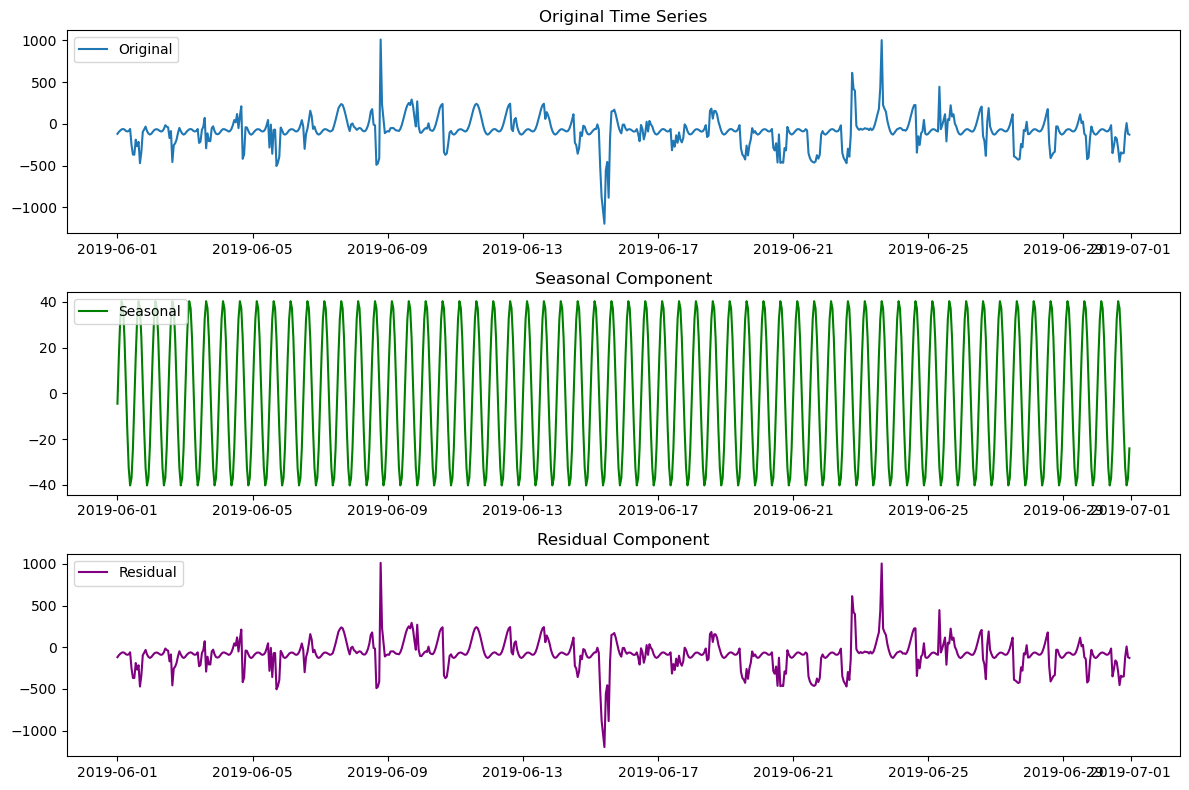

720


In [ ]:
def decompose_fourier_multiple(data, seasonal_periods):
    # Compute FFT of the time series data
    fft_values = np.fft.fft(data)
    
    # Compute the frequencies corresponding to the FFT values
    frequencies = np.fft.fftfreq(len(data))
    
    # Initialize reconstructed signal as zeros
    reconstructed_signal = np.zeros_like(fft_values)
    
    # Iterate over seasonal periods
    for period in seasonal_periods:
        # Find the index of the highest amplitude frequency for the current period (excluding the DC component)
        highest_freq_index = np.argmax(np.abs(fft_values[1:])) + 1
        
        # Construct the signal corresponding to the highest amplitude frequency
        reconstructed_signal[highest_freq_index] = fft_values[highest_freq_index]
        
        # Compute the seasonal component by keeping only the highest amplitude frequency for the current period
        seasonal_component = np.fft.ifft(reconstructed_signal)
        
        # Subtract the seasonal component from the original signal
        data -= seasonal_component
        
        # Reset the reconstructed signal for the next seasonal component
        reconstructed_signal = np.zeros_like(fft_values)
    
    # Compute the residual component (what remains after removing all seasonal components)
    residual_component = data
    
    return seasonal_component, residual_component

# Decompose the time series data using Fourier transform with multiple seasonal components
seasonal, residual = decompose_fourier_multiple(df['net_load'], seasonal_periods=[24])  # Example seasonal periods

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(311)
plt.plot(df.index, df['net_load'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(312)
plt.plot(df.index, seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(313)
plt.plot(df.index, residual, label='Residual', color='purple')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()
print(len(seasonal))

c:\Users\xlow6\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


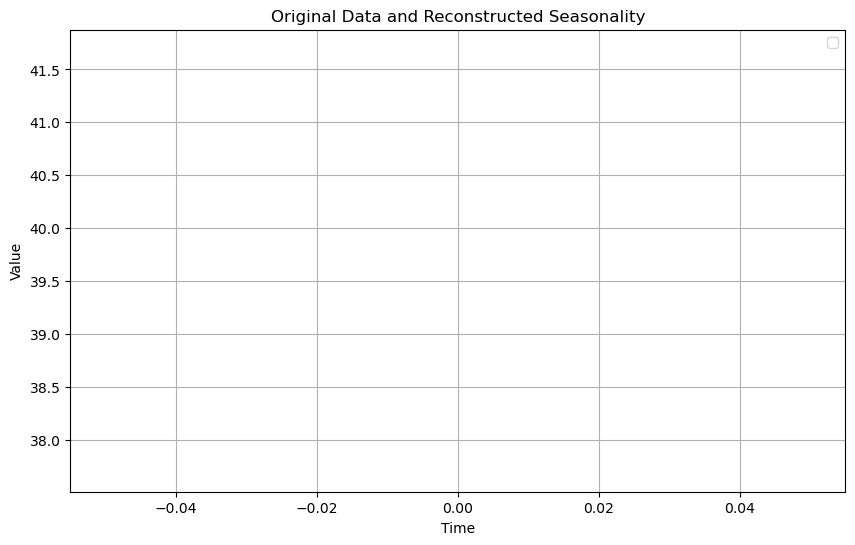

In [ ]:
from scipy.optimize import curve_fit

T_d = 24  # Period of one day (in hours)
T_y = 365 * 24  # Period of one year (in hours)

def fourier_series(t, a0, *params):
    N = len(params) // 6  # Number of harmonics
    an = params[:N]
    bn = params[N:2*N]
    cm = params[2*N:3*N]
    dm = params[3*N:]
    series_day = sum(a * np.cos(2 * np.pi * n * t / T_d) + b * np.sin(2 * np.pi * n * t / T_d) for n, (a, b) in enumerate(zip(an, bn), start=1))
    series_year = sum(c * np.cos(2 * np.pi * m * t / T_y) + d * np.sin(2 * np.pi * m * t / T_y) for m, (c, d) in enumerate(zip(cm, dm), start=1))
    print(series_day)
    print(series_year)
    return a0 + series_day + series_year

# Initial guess for parameters
initial_guess = [np.mean(df['net_load'])] + [0] * 4

# Fit Fourier series to data
params, _ = curve_fit(fourier_series, np.arange(len(df)), df['net_load'], p0=initial_guess)

# Reconstruct seasonality
seasonality = fourier_series(np.arange(len(df)), params[0],params)

# Plot original data and reconstructed seasonality
plt.figure(figsize=(10, 6))
#plt.plot(df.index, df['net_load'], label='Observed Data', color='blue')
plt.plot(seasonality)
#plt.plot(df.index, seasonality, label='Seasonality', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original Data and Reconstructed Seasonality')
plt.legend()
plt.grid(True)
plt.show()